# <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:200%; text-align:center;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0">S3E26 - STACKING CLASSIFIER</div>
Notebook edited from [dreygaen/ps3e25-cirrhosis-multi-class-solution](https://www.kaggle.com/code/dreygaen/ps3e25-cirrhosis-multi-class-solution)
#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:150%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >TABLE OF CONTENTS<br><div>
* [IMPORTS](#1)
* [LOAD DATA](#2)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > IMPORTS<br><div> 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import zipfile

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import (ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, 
                              RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, 
                              HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, StackingClassifier)
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (median_absolute_error, roc_auc_score, roc_curve, log_loss, ConfusionMatrixDisplay,
                              confusion_matrix)
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from sklego.linear_model import LADRegression
import optuna
from itertools import combinations, permutations

optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
tqdm.pandas()

rc = {
    'axes.facecolor': '#FFEDED',
    'figure.facecolor': '#FFEDED',
    'axes.edgecolor': '#000000',
    'grid.color': '#EBEBE7',
    'font.family': 'serif',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'grid.alpha': 0.4
}

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL
bold_start = Style.BRIGHT
bold_end = Style.NORMAL

target_col = 'Status'

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > LOAD DATA<br><div> 

In [2]:
with zipfile.ZipFile('../../../res/data/playground-series-s3e26.zip', 'r') as z:
    
    with z.open('train.csv') as f:
        train = pd.read_csv(f, index_col = 'id')        
                
    with z.open('test.csv') as f:
        test = pd.read_csv(f, index_col = 'id')
    
    with z.open('sample_submission.csv') as f:
        submission = pd.read_csv(f)
        
with zipfile.ZipFile('../../../res/data/cirrhosis-patient-survival-prediction.zip', 'r') as z:
    with z.open('cirrhosis.csv') as f:
        orig_data = pd.read_csv(f, index_col = 'ID') 

In [3]:
train = pd.concat([train, orig_data], axis=0, ignore_index=True)
cat_cols = train.select_dtypes(include = ['O']).columns

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >Feature Engineering<br><div> 

In [4]:
# original notebook applied fit_transform on training data.
train_cat_cols = train.select_dtypes(include=['object']).columns
for col in train_cat_cols:
    label_encoder = LabelEncoder()
    train[col] = label_encoder.fit_transform(train[col])
    if col != target_col:
        test[col] = label_encoder.transform(test[col])

In [5]:
# train_drop = train.dropna()
# X = train_drop.drop([target_col], axis=1)
# y = train_drop[target_col]

X = train.drop([target_col], axis=1)
y = train[target_col]

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > MODELS<br><div> 

In [17]:
N_FOLDS = 5
N_REPEATS = 1
random_state = 24424422
k_fold = RepeatedStratifiedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=random_state)


xgb_set_params = {
    'objective': 'multi_logloss', 
    'max_depth': 3, 
    'learning_rate': 0.010009541152584345, 
    'n_estimators': 2600,
    'min_child_weight': 9, 
    # 'colsample_bytree': 0.3292032860985591, 
    # 'reg_alpha': 0.10626128775335533, 
    # 'reg_lambda': 0.624196407787772, 
    'tree_method': 'hist', 
    'eval_metric': 'mlogloss',
    # 'subsample': 0.47524425009347593
    'random_state': random_state,
}

cat_set_params = {
    'iterations':1000,
    # 'depth': 20,
    'learning_rate': 0.138112945166,
    'l2_leaf_reg': 4.0368544113430485,
    'random_strength': 0.1279482215776108,
    'max_bin': 238,
    'od_wait': 49,
    'one_hot_max_size': 39,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bernoulli',
    'od_type': 'IncToDec', #'Iter',    
    'min_data_in_leaf': 6,
    'loss_function': 'MultiClass',
    'verbose': False,
}

lgbm_set_params = {
    'objective': 'multiclass', #'multi_logloss', 
    'num_class': 3,
    'metric': 'multi_logloss',
    'max_depth': 21, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 250, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'verbose': -1,
    'random_state': random_state,
}

# hgb_set_params = {
#     # 'learning_rate': 1,
#     # 'max_iter': 100,
#     'max_leaf_nodes': 31,
#     'max_depth': None,
#     'min_samples_leaf': 20,
#     'l2_regularization': 0,
#     'max_bins': 255,
#     'categorical_features': [col for col in cat_cols if col != target_col],
#     'monotonic_cst': None,
#     'interaction_cst': None,
#     'scoring': 'log_loss',
#     'validation_fraction': 0.1,
#     # 'class_weight': None,
# }



def objective(trial):
    xgb_params = (
        xgb_set_params | 
        {  
            'reg_alpha': trial.suggest_float("xgb_reg_alpha", 0.025, 0.075, log=False),
            'reg_lambda': trial.suggest_float("xgb_reg_lambda", 0.65, 0.8, log=False),    
            'subsample': trial.suggest_float("xgb_subsample", 0.4, 0.45, log=False),
            'colsample_bytree': trial.suggest_float("xgb_colsample_bytree", 0.4, 0.5, log=False),
        })
    
    cat_params = (
        cat_set_params | 
        {  
            'max_depth': trial.suggest_int("cat_max_depth", 10, 25, log=False),
        })
    
    lgbm_max_depth = lgbm_set_params['max_depth']
    
    lgbm_params = (lgbm_set_params | 
        {
            'num_leaves': 2**lgbm_max_depth - 1 if 2**lgbm_max_depth - 1 <= 131072 else 131072,
            # 'min_child_samples': trial.suggest_int("lgbm_min_child_samples", 10, 15, log=False), 
            'min_gain_to_split': trial.suggest_float("lgbm_min_gain_to_split", 0.0, 0.1, step=0.01),
            # 'learning_rate':trial.suggest_float("lgbm_learning_rate", 0.02, 0.04, log=False), 
            # 'n_estimators': trial.suggest_int("lgbm_n_estimators", 250, 300, step=5), 
            # 'colsample_bytree': trial.suggest_uniform("lgbm_colsample_bytree", 2/18, 5/18), 
            'class_weight': trial.suggest_categorical("lgbm_class_weight", ['balanced', None]),            
            
        })
    
    # hgb_params = (hgb_set_params | 
    #     {
    #         'learning_rate': trial.suggest_loguniform("hgb_learning_rate", 0.025, 0.25),
    #         'max_iter': trial.suggest_int("hgb_max_iter", 100, 500, step=50),
    #         # 'max_leaf_nodes': 31,
    #         # 'max_depth': None,
    #         # 'min_samples_leaf': 20,
    #         # 'l2_regularization': 0,
    #         # 'max_bins': 255,
    #         # 'monotonic_cst': None,
    #         # 'interaction_cst': None,
    #         # 'scoring': 'log_loss',
    #         # 'validation_fraction': 0.1,
    #         'class_weight': trial.suggest_categorical("hgb_class_weight", ['balanced', None]),            
    #     })
    # List of potential classifiers
    classifier_options = {
        "XGBClassifier": XGBClassifier(**xgb_params),
        # 'HistGradientBoostingClassifier': HistGradientBoostingClassifier(**hgb_params),
        "CatBoostClassifier": CatBoostClassifier(**cat_params),
        # "LGBMClassifier": LGBMClassifier(**lgbm_params),
    }
    base_classifiers=[(k, v) for k, v in classifier_options.items()]

    # # Select two classifiers
    # selected_classifier_1 = trial.suggest_categorical("base_classifier_1", list(classifier_options.keys()))
    # # c1 = classifier_options.pop(selected_classifier_1)
    # selected_classifier_2 = trial.suggest_categorical("base_classifier_2", list(classifier_options.keys()))
    # 
    # if selected_classifier_1 == selected_classifier_2:
    #     base_classifiers = [
    #         (selected_classifier_1, classifier_options[selected_classifier_1]),         
    #     ]
    # else:
    #     base_classifiers = [
    #         (selected_classifier_1, classifier_options[selected_classifier_1]),
    #         (selected_classifier_2, classifier_options[selected_classifier_2])
    #     ]
    
    # selected_classifiers = trial.suggest_categorical("base_classifiers", list(classifier_options.keys()))
    # base_classifiers = [(selected_classifiers, classifier_options[selected_classifiers])]
    
    # List of potential meta classifiers
    # meta_classifier_options = {
    #     "XGBClassifier": XGBClassifier(
    #         max_depth=trial.suggest_int("xgb_max_depth", 4, 10, log=True),
    #         **xgb_params),
    #     "CatBoostClassifier": CatBoostClassifier(
    #         depth=trial.suggest_int("cat_depth", 2, 32, log=True),
    #         **cat_params),
    #     # "LGBMClassifier": LGBMClassifier(
    #     #     max_depth=trial.suggest_int("lgbm_max_depth", 6, 9, log=True),
    #     #     **lgbm_params),
    # }
    #     # Select two classifiers
    # selected_meta_classifier = trial.suggest_categorical("meta_classifier", list(meta_classifier_options.keys()))
    # 
    # # Meta-classifier
    # meta_classifier = meta_classifier_options[selected_meta_classifier]
    stack_params = {
        'stack_method': 'predict_proba', #trial.suggest_categorical("stack_method", ['predict_proba']),
        'passthrough': True #trial.suggest_categorical("passthrough", [True, False])
    }
    # Stacking Classifier
    classifier = StackingClassifier(
        estimators=base_classifiers, 
        final_estimator=LGBMClassifier(**lgbm_params),
        # stack_method = 'predict_proba',
        # passthrough=True, # final estimator trained on predictions and data
        **stack_params
    )

    score = cross_val_score(classifier, X, y, n_jobs=-1, cv=k_fold, scoring='neg_log_loss')
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="stacking-v2-1",
    direction='maximize',
    load_if_exists=True,
)
study.optimize(objective, n_trials=10, show_progress_bar=True)

print(study.best_trial)


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-12-20 15:13:34,561] Trial 4 failed with parameters: {'xgb_reg_alpha': 0.061219871150917, 'xgb_reg_lambda': 0.6708875473734291, 'xgb_subsample': 0.44906092204815207, 'xgb_colsample_bytree': 0.4419172917142154, 'cat_max_depth': 19, 'lgbm_min_gain_to_split': 0.02, 'lgbm_class_weight': 'balanced'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/4z/1z6hg6gd23q9cdgl0sgrry8c0000gn/T/ipykernel_70187/3392608880.py", line 175, in objective
    score = cross_val_score(classifier, X, y, n_jobs=-1, cv=k_fold, scoring='neg_log_loss')
  File "/Users/seanbearden/PycharmProjects/Kaggle/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "/Users/seanbearden/PycharmProjects/Kaggl

KeyboardInterrupt: 

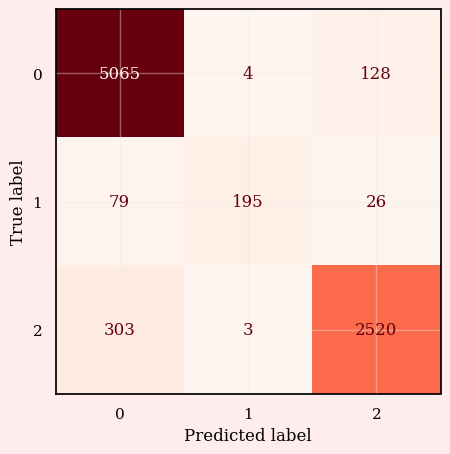

In [13]:
best_params = study.best_params

lgbm_max_depth = lgbm_set_params['max_depth']

classifier_options = {
        "XGBClassifier": XGBClassifier(**(
                xgb_set_params | 
                {k[4:]:v for k, v in best_params.items() if 'xgb_' in k}
        )),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(**(
            hgb_set_params | {k[4:]:v for k, v in best_params.items() if 'hgb_' in k}
        )),
        # "CatBoostClassifier": CatBoostClassifier(**cat_params),
        # "LGBMClassifier": LGBMClassifier(**lgbm_params),
    }
base_classifiers=[(k, v) for k, v in classifier_options.items()]

classifier = StackingClassifier(
        estimators=base_classifiers, 
        final_estimator=LGBMClassifier(
            num_leaves=2**lgbm_max_depth - 1 if 2**lgbm_max_depth - 1 <= 131072 else 131072,
            **(
                lgbm_set_params | {k[4:]:v for k, v in best_params.items() if 'lgbm_' in k}
            )
        ),
        stack_method=best_params['stack_method'],
        passthrough=best_params['passthrough'], # final estimator trained on predictions and data
    )

classifier.fit(X, y)

y_pred_cm = classifier.predict(X)

fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(y, y_pred_cm, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Reds, ax= ax, 
colorbar=False, text_kw={"fontsize":12})
plt.show()

In [14]:
y_pred = classifier.predict_proba(X)
print(f'log loss: {log_loss(y, y_pred)}')

log loss: 0.20772688822558116


<table style="border: 2px solid purple;">
  <tr>
    <th style="border: 2px solid purple;">Version</th>
    <th style="border: 2px solid purple;">Log Loss</th>
    <th style="border: 2px solid purple;">Public Score</th>
    <th style="border: 2px solid purple;">Note</th>
  </tr>
  <tr>
    <td style="border: 2px solid purple;">v2</td>
    <td style="border: 2px solid purple;">0.20772688822558116</td>
    <td style="border: 2px solid purple;"></td>
    <td style="border: 2px solid purple;"></td>
  </tr>

</table>



<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > SUBMISSION<br><div> 

In [15]:
pred = classifier.predict_proba(test)

submission['Status_C'] =  pred[:, 0]
submission['Status_CL'] = pred[:, 1]
submission['Status_D'] =  pred[:, 2]

submission.to_csv('submission.csv', index = False)

In [16]:
%%bash
kaggle competitions submit playground-series-s3e26 -f submission.csv -m "Stacking v2"
kaggle competitions submissions playground-series-s3e26

100%|██████████| 337k/337k [00:02<00:00, 127kB/s] 


Successfully submitted to Multi-Class Prediction of Cirrhosis OutcomesfileName        date                 description                                            status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------------------  --------  -----------  ------------  
submission.csv  2023-12-20 22:44:55  Stacking v2                                            complete  0.4095                     
submission.csv  2023-12-20 16:15:37  Voting v4-1                                            complete  0.39475                    
submission.csv  2023-12-20 13:35:34  Voting v4                                              complete  0.3944                     
submission.csv  2023-12-20 01:41:35  Voting v3-1                                            complete  0.396                      
submission.csv  2023-12-19 10:58:53  Voting v3-0                                            complete  0.39554                    
submission.csv  2023